# Figure 1:

Here we will provide the code on how to make Figure 1 in https://arxiv.org/abs/2308.07810

In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from _funcs import *

import seaborn as sns
plt.rc('text', usetex=True)
sns.set()

def get_first_hit(array, x):
    # create a function that returs first hitting time of array >= x
    try: 
        return np.min(np.where(array>=x))
    except ValueError:
        return None
    

def dynamical_activity(n, gamma, omega):
    numerator = 2 * (1 + 2 * n) * gamma * (n * (1 + n) * gamma**2 + 2 * omega**2)
    denominator = ((gamma + 2 * n * gamma)**2 + 8 * omega**2)
    return numerator / denominator

def quantum_dynamical_activity(n, gamma, Omega):
    numerator = 64 * Omega**2 * (gamma**2 * n * (n+1) + 2 * Omega**2)
    denominator = 8 * gamma * (2*n+1) * Omega**2 + (gamma + 2*gamma*n)**3
    return numerator / denominator


In [14]:
# Parameters
gamma = 1
nbar = 0.2
Omega = 1
dt = 0.0003
dts = 0.01
tf = 30
t = np.arange(0, tf, dt)
ts = np.arange(0, tf, dts)

# Define system operators
sp = sigmap()
sm = sigmam()
sx = sigmax()
sz = sigmaz()
H = Omega*sx

# define dissipator and Hamiltonian
c_ops = [np.sqrt(gamma * (1+nbar)) * sm, np.sqrt(gamma * nbar) * sp]    
H_eff = H - 0.5j * sum([c_op.dag() * c_op for c_op in c_ops])

# steadystate
rho_ss = steadystate(H, c_ops)

# Compute dynamical activity per unity time
K = sum([expect(c_op.dag() * c_op, rho_ss) for c_op in c_ops])
Q = quantum_dynamical_activity(nbar, gamma, Omega)

In [20]:
# number of chargers to truncate at 
Nm = 50
dN = 1
N_cutoff = 5
N = np.arange(-20, N_cutoff, dN)
# Compute initial state
rho0 = operator_to_vector(steadystate(H, c_ops))
nu_k = [0, -1, 1]

#----------------- Solve -----------------#
proj = ProjectiveEvolutionPntAbsorb(H_eff, c_ops, t, N, N_cutoff-1)
Pn_vec = proj.solve(rho0, nu_k)

# Compute survival probability
P0 = np.sum(Pn_vec, axis=0)
dGt = -np.gradient(P0, dt)

Initial state is already in vector form


Evolution Superoperator: 100%|██████████| 100000/100000 [00:14<00:00, 6688.45it/s]


In [25]:
# qutip evolution
result = photocurrent_mesolve(H, rho_ss, ts, sc_ops=c_ops, e_ops=[sz], store_measurement=True, ntraj=5000)

10.0%. Run time:   5.91s. Est. time left: 00:00:00:53
20.0%. Run time:  12.00s. Est. time left: 00:00:00:48
30.0%. Run time:  18.00s. Est. time left: 00:00:00:41
40.0%. Run time:  24.30s. Est. time left: 00:00:00:36
50.0%. Run time:  30.47s. Est. time left: 00:00:00:30
60.0%. Run time:  36.55s. Est. time left: 00:00:00:24
70.0%. Run time:  42.71s. Est. time left: 00:00:00:18
80.0%. Run time:  48.86s. Est. time left: 00:00:00:12
90.0%. Run time:  54.90s. Est. time left: 00:00:00:06
Total run time:  60.97s


In [26]:
# Get measurement trajectories
dNm = np.real(np.array(result.measurement)[:, :, 0])*dts
dNp = np.real(np.array(result.measurement)[:, :, 1])*dts

# Compute photocurrent
J = np.cumsum(dNm - dNp, axis=1)

In [27]:
# Get first hitting times
inds = np.array([get_first_hit(mi, N_cutoff) for mi in J])
inds = inds[inds != None]

# Get first hitting times
hitting_times = ts[list(inds)]

In [28]:
# Compute mean and variance of distribution
Et = np.sum(dGt * t)*dt
Var = np.sum(dGt * t**2 )*dt - Et**2

SNR = Et**2 / Var

print(SNR/(Et*K), 1)
print(SNR/(Et*(K+Q)), 1)

0.6709709478602643 1
0.03872506059499759 1


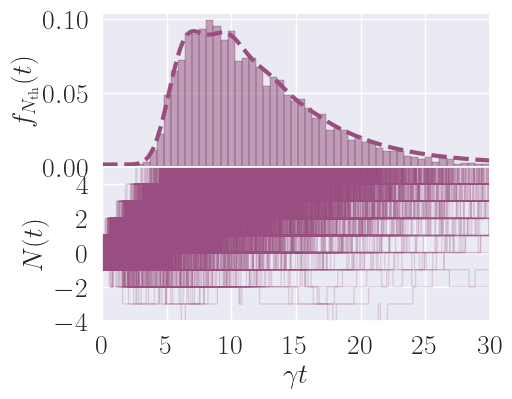

In [29]:
#----------------- Plotting -----------------#

fig = plt.figure(figsize=(5, 4))

color = [0.6, 0.3, 0.5]

plt.subplot(2, 1, 1)
# plt.plot(t, P0, color='k', linestyle='-', linewidth=3, alpha=1)
plt.plot(t, dGt+0.002, color=color, linestyle='--', linewidth=3, alpha=1)
plt.hist(hitting_times, density=True, bins=50, color=color, alpha=0.5, edgecolor='k', linewidth=0.3)
# plt.vlines(Et, 0, dGt[np.argmin(np.abs(t-Et))], color='k', linestyle='--', linewidth=2, alpha=1)

plt.xticks(np.arange(0, tf+5, 5), [], fontsize=20)
plt.yticks(np.arange(0.0, 0.15, 0.05), fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim(0.0, 0.15)
plt.xlim(0, tf)
plt.ylabel(r"$f_{N_{\rm th}}(t)$", fontsize=20)


plt.subplot(2, 1, 2)
plt.plot(ts, J.T, color=color, linestyle='-', linewidth=1, alpha=0.2)

plt.yticks(fontsize=20)
plt.xticks(np.arange(0, tf+5, 5), fontsize=20)
plt.ylim(-4, N_cutoff)
plt.xlim(0, tf)

plt.xlabel(r'$\gamma t$', fontsize=20)
plt.ylabel(r'$N(t)$', fontsize=20)

plt.subplots_adjust(hspace=0.0)

plt.show()

#----------------- Save -----------------#
# fig.savefig('Figures/Garrahan2_example.png', bbox_inches='tight', dpi=200)

# Repeat analysis but loop over different values of $\bar{n}$ and $\Omega$ creating a surface plot of the SNR

In [2]:
saved_data = True

# parameters
nbars = [0.1, 0.5, 1]
Omegas = np.linspace(0.0, 3, 100)
gamma = 1

if saved_data:
    # load data
    import pickle 
    # load the dictionary
    with open('Data/data3.pickle', 'rb') as handle:
        data = pickle.load(handle)

    # upack data
    Et_vals = data['Et_vals']
    Var_vals = data['Var_vals']
    SNR_vals = data['SNR_vals']
    K_vals = data['K_vals']
    Q_vals = data['Q_vals']
    nbars = data['nbar']
    Omegas = data['Omega']

else:

    # time parameters
    dt = 0.00025
    tf = 100
    t = np.arange(0, tf, dt)

    # Define system operators
    sp = sigmap()
    sm = sigmam()
    sx = sigmax()
    sz = sigmaz()

    # counting params
    nu_k = [0, -1, 1]
    # number of chargers to truncate at 
    Nm = 50
    dN = 1
    N_cutoff = 5
    N = np.arange(-10, Nm, dN)

    # initialise matrices
    Et_vals = np.zeros((len(nbars), len(Omegas)))
    Var_vals = np.zeros((len(nbars), len(Omegas)))
    SNR_vals = np.zeros((len(nbars), len(Omegas)))
    K_vals = np.zeros((len(nbars), len(Omegas)))
    Q_vals = np.zeros((len(nbars), len(Omegas)))

    count = 1

    for i, nbar in enumerate(nbars):
        for j, Omega in enumerate(Omegas):
            
            print('nbar = ', nbar, 'Omega = ', Omega)
            print(count, 'out of', len(nbars)*len(Omegas), 'iterations')
            count += 1
            
            # Define Hamiltonian
            H = Omega*sx

            # define dissipator and Hamiltonian
            c_ops = [np.sqrt(gamma * (1+nbar)) * sm, np.sqrt(gamma * nbar) * sp]    
            H_eff = H - 0.5j * sum([c_op.dag() * c_op for c_op in c_ops])

            # steadystate
            rho_ss = steadystate(H, c_ops)

            # Compute dynamical activity per unity time
            K_vals[i, j] = dynamical_activity(nbar, gamma, Omega)
            Q_vals[i, j] = quantum_dynamical_activity(nbar, gamma, Omega)

            # Compute initial state
            rho0 = operator_to_vector(steadystate(H, c_ops))

            #----------------- Solve -----------------#
            proj = ProjectiveEvolutionPntAbsorb(H_eff, c_ops, t, N, N_cutoff-1)
            Pn_vec = proj.solve(rho0, nu_k)

            # Compute survival probability
            P0 = np.sum(Pn_vec, axis=0)
            dGt = -np.gradient(P0, dt)

            # Compute mean and variance of distribution
            Et = np.sum(dGt * t)*dt
            Var = np.sum(dGt * t**2 )*dt - Et**2

            SNR = Et**2 / Var

            # Compute mean and variance of distribution
            Et_vals[i, j] = Et
            Var_vals[i, j] = Var

            SNR_vals[i, j] = SNR

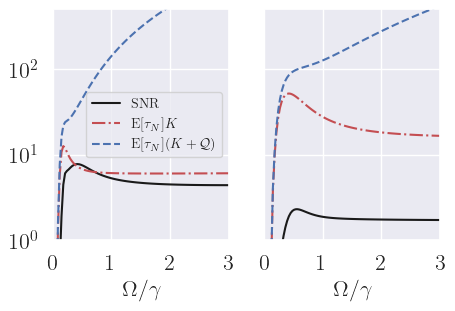

In [94]:
# compute both inequalitys
ineq1 = (Et_vals*K_vals)
ineq2 = (Et_vals*(K_vals+Q_vals))

# plot as a function of Omega
fig = plt.figure(figsize=(5, 3))

fs = 16
lw = 1.5

colors = ['k', 'r', 'b']

plt.subplot(1, 2, 1)
plt.plot(Omegas, SNR_vals[0], '-', color=colors[0], linewidth=lw, label=r'${\rm SNR}$')
plt.plot(Omegas, ineq1[0], '-.', color=colors[1], linewidth=lw, label=r'${\rm E}[\tau_{N}]K$')
plt.plot(Omegas, ineq2[0], '--', color=colors[2], linewidth=lw, label=r'${\rm E}[\tau_{N}](K+\mathcal{Q})$')

# plt.fill_betweenx([1, 5], 0, Omegas[-1], color='r', alpha=0.2)
plt.xlim(0.11, Omegas[-1])
plt.ylim(1, 500)

plt.yticks([1, 10, 100], fontsize=fs)
plt.xticks([0, 1, 2, 3], fontsize=fs)
plt.xlabel(r'$\Omega/\gamma$', fontsize=fs)
# plt.ylabel(r'${\rm SNR}_{\tau}/K_{\tau}  $', rotation=90, fontsize=20)

plt.legend(fontsize=10)
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(Omegas, SNR_vals[2], '-', color=colors[0], linewidth=lw)
plt.plot(Omegas, ineq1[2], '-.', color=colors[1], linewidth=lw)
plt.plot(Omegas, ineq2[2], '--', color=colors[2], linewidth=lw)

# plt.fill_betweenx([1, 5], 0, Omegas[-1], color='r', alpha=0.2)
plt.xlim(0.11, Omegas[-1])
plt.ylim(1, 500)

plt.xticks([0, 1, 2, 3], fontsize=fs)
plt.xlabel(r'$\Omega/\gamma$', fontsize=fs)

# plt.legend(fontsize=16, loc=(0.6,0.15))
plt.yscale('log')

plt.yticks([1, 10, 100], [], fontsize=fs)
# plt.xscale('log')

plt.show()

fig.savefig('Figures/inequality_f.png', bbox_inches='tight', dpi=200)